In [1]:
%matplotlib inline
import numpy as np
import os,random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
TRAIN_PATH="DATA/chest_xray/train/"
VAL_PATH="DATA/chest_xray/val/"
TEST_PATH="DATA/chest_xray/test/"


2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
for img_class in os.listdir(TRAIN_PATH):
    print(str(len(os.listdir(TRAIN_PATH + img_class ))) + " " + img_class + " train images")

for img_class in os.listdir(VAL_PATH):
    print(str(len(os.listdir(VAL_PATH + img_class ))) + " " + img_class + " val images")

for img_class in os.listdir(TEST_PATH):
    print(str(len(os.listdir(TEST_PATH + img_class ))) + " " + img_class + " test images")

1207 NORMAL train images
3488 PNEUMONIA train images
142 NORMAL val images
395 PNEUMONIA val images
234 NORMAL test images
390 PNEUMONIA test images


NORMAL2-IM-1279-0001.jpeg (1476, 1956)


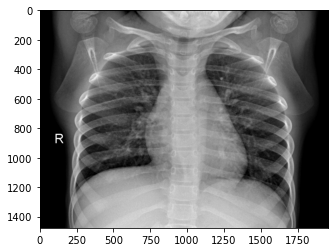

In [3]:
np.random.seed(42)
normal_image=np.random.choice(os.listdir(TRAIN_PATH+"NORMAL/"))
im=img.imread(TRAIN_PATH+"NORMAL/"+normal_image)
print(normal_image,im.shape)
plt.imshow(im,cmap='gray')
plt.show()

person578_bacteria_2379.jpeg (763, 1068)


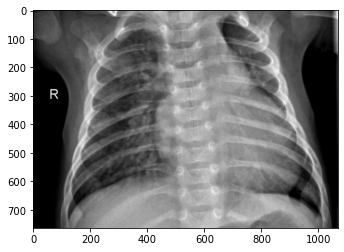

In [23]:
np.random.seed(76)
p_image=np.random.choice(os.listdir(TRAIN_PATH+"PNEUMONIA/"))
im=img.imread(TRAIN_PATH+"PNEUMONIA/"+p_image)
print(p_image,im.shape)
plt.imshow(im,cmap='gray')
plt.show()

In [5]:
input_shape=(128,128)
batch_size=64

train_gen=ImageDataGenerator( rescale = 1./255,shear_range=0.3,
                             zoom_range=0.3,horizontal_flip=True )

train_data=train_gen.flow_from_directory( TRAIN_PATH,
                                             target_size=input_shape,
                                             batch_size=batch_size,
                                             color_mode='grayscale',
                                             class_mode='binary',
                                             shuffle=True,
                                             seed=42 )


Found 4695 images belonging to 2 classes.


In [6]:
val_gen=ImageDataGenerator( rescale=1./255 )

val_data=val_gen.flow_from_directory( VAL_PATH,
                                             target_size=input_shape,
                                             batch_size=batch_size,
                                             color_mode='grayscale',
                                             class_mode='binary')

Found 537 images belonging to 2 classes.


In [7]:
test_gen=ImageDataGenerator( rescale=1./255 )

test_data=test_gen.flow_from_directory( TEST_PATH,
                                      target_size=input_shape,
                                      batch_size=batch_size,
                                      color_mode='grayscale',
                                      class_mode='binary')


Found 624 images belonging to 2 classes.
